# Animation of disease age dynamics

Nils Bruin and Alexa van der Waall, April 11, 2020

This notebook provides an illustration and consistency check on the contact tracing dynamics. We choose a disease that is infective strictly before it's symptomatic, and which is symptomatic in a lot of patients. Individuals get diagnosed and quarantined when they develop symptoms, but that does not influence the epidynamics directly. The contact tracing of these individuals does, however.

In [1]:
%matplotlib inline
import numpy as np
from numpy import exp, abs, log, floor
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
from IPython.display import HTML
def prod(L): return reduce(mul,L)

#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy,time_scale=1.0):
        
        #conversion between real time and discrete time step number
        self.N = N
        Tfactor = N/time_scale
        self.Tfactor = Tfactor
        
        #discretize distributions
        beta=[quad(beta_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        symptom_onset_prop=[quad(q_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        q=[]
        symptomatic_prop=[]
        running_total=0
        for i in range(N):
            q.append(symptom_onset_prop[i]/(1-running_total))
            running_total+=symptom_onset_prop[i]
            symptomatic_prop.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(symptom_onset_prop)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.symptom_onset_prop=symptom_onset_prop
        self.symptomatic_prop=symptomatic_prop
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._betaprime=[]
        self.I0=I0
        self.N=N
        self.policy=policy
        self._policy=[]
        self.time_scale=time_scale

        
    #conversion function between real time and step number (t is real time; T is step number)
    def T_from_t(self,t):
        return int(floor(t*self.Tfactor))
    def t_from_T(self,T):
        return T/self.Tfactor
    def time_step_list(self,t0,t1):
        return np.arange(t0,t1,1/self.Tfactor)
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else 1-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 0
    def I(self,T):
        return self._I[T] if T>=0 else list(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else list(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else list(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,self.t_from_T(T))
        self._policy.append(policyT)
        C_quar,C_contact,C_test,C_trace=policyT
        Ctst=C_test/self.Tfactor
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(C_quar*c+Ctst)*i for c,i in zip(self.q,IT)]
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        for dT in range(self.N-1,-1,-1):
            for age in range(dT,self.N):
                Qnew[dT]+=self.betaprime(T-dT)[age-dT]*Qnew[age]*C_trace
        Qnew=[min(i,q) for i,q in zip(IT,Qnew)]
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=self.T_from_t(t)
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def disease_plots(self,include_cond_dist=True):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        Tfactor=self.Tfactor
        stride=1/Tfactor
        time_scale=self.time_scale
        t_range=np.arange(0,time_scale,time_scale/100)

        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in t_range]
        ticks=np.arange(stride/2,time_scale,stride)
        R0=sum(self.beta)
        ax1.bar(ticks,[i*Tfactor for i in self.beta],alpha=0.5,width=stride,label="infectivity integrated\n over intervals")
        ax1.plot(t_range,fvals,color="black",label="infectivity density")
        ax1.set_title("Infectivity (area=R0)")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        R0_label_y=max(fvals)/10
        R0_label_x=time_scale/10
        ax1.text(R0_label_x,R0_label_y,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in t_range]
        ax2.plot(t_range,fvals,color="black",label="density")
        ax2.bar(ticks,[i*Tfactor for i in self.symptom_onset_prop],alpha=0.5,width=stride,label="integrated")
        if include_cond_dist:
            ax2.bar(ticks,[i*Tfactor for i in self.q],alpha=0.2,color="red",width=stride,label="conditional rates")
        ax2.set_title("Symptom distribution")
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("symptom rate")

        ax3.set_title("asymptomatic infected proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("asymptomatic proportion")
        ax3.text(R0_label_x,0.1,"asymptomatic proportion = {:3.3}".format(1-self.symptomatic_prop[-1]))
        ax3.bar(ticks,[1-p for p in self.symptomatic_prop],alpha=0.5,width=stride)

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.symptomatic_prop,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity (area=R0q)")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        ax4.text(R0_label_x,R0_label_y,"R0q = {:3.3}".format(R0q))
        ax4.bar(ticks,[c*Tfactor for c in q_adjusted_infection_coefficient],alpha=0.5,width=stride)
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        fig, (ax2,ax1,ax3) = plt.subplots(1,3)
        fig.set_size_inches(16,5)
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined",color="red")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active",color="orange")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined",color="green")
        ax1.legend(loc="upper right")
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active",color="orange")
        ax2.plot(times,r,label="removed",color="green")
        ax2.legend()
        ax2.set_ylim([0,1])
        ax3.set_title("policy")
        ax3.set_ylim([0,1.01])
        ax3.set_xlabel("time")
        ax3.set_ylabel("measure intensity")
        policy=self._policy[:T]        
        ax3.plot(times,[a[0] for a in policy],label="self-quarantining")
        ax3.plot(times,[1-a[1] for a in policy],label="physical distancing")
        ax3.plot(times,[a[2] for a in policy], label="surveilance testing")
        ax3.plot(times,[a[3] for a in policy],label="contact tracing")
        ax3.legend()
        return fig

# code to generate an animation of the infected and quarantined age distributions through time
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def anim(sim,ymax):
    fig, ax = plt.subplots()
    ages=list(np.linspace(0,sim.time_scale,sim.N))

    sublist = [ i for i,a in enumerate(ages) if 5<=a<=15]
    infective_slice = slice(min(sublist),max(sublist)+1)
    sublist = [ i for i,a in enumerate(ages) if 15<=a<=19]
    symptom_slice = slice(min(sublist),max(sublist)+1)

    t0=300
    I=sim.I(t0)
    line1, = ax.plot(ages,sim.I(t0),label="infected unquarantined",color="red")
    line2, = ax.plot(ages,[q+i for q,i in zip(sim.Q(t0),sim.I(t0))],label="total active",color="orange")
    line3, = ax.plot(ages,sim.Q(t0),label="quarantined",color="green")
    region1 = ax.fill_between(ages[infective_slice],line1.get_ydata()[infective_slice],color="red",alpha=0.2,label="infective")
    region2 = ax.fill_between(ages[symptom_slice],line1.get_ydata()[symptom_slice],color="green",alpha=0.2,label="symptom onset")
    reg=[region1,region2]
    ax.set_ylim([0,ymax])
    ax.legend(loc="upper right")
    ax.set_xlabel("infection age")
    ax.set_ylabel("proportion of population")
    ax.set_title("Infected population and demographics")
    def init():  # only required for blitting to give a clean slate.
        line1.set_ydata([np.nan] * len(ages))
        line2.set_ydata([np.nan] * len(ages))
        line3.set_ydata([np.nan] * len(ages))
        return [line1,line2,line3]

    def animate(i):
        t=i
        I=sim.I(t)
        line1.set_ydata(I)  # update the data.
        line2.set_ydata([i+q for i,q in zip(sim.I(t),sim.Q(t))])  # update the data.
        line3.set_ydata(sim.Q(t))  # update the data.
        reg[0].remove()
        reg[0] = ax.fill_between(ages[infective_slice],I[infective_slice],color="red",alpha=0.2)
        reg[1].remove()
        reg[1] = ax.fill_between(ages[symptom_slice],I[symptom_slice],color="green",alpha=0.2)
        return line1, line2, line3, region1, region2

    ani = animation.FuncAnimation(
        fig, animate,frames=range(len(sim._Q)),init_func=init, interval=5, blit=True, save_count=500,repeat=True)
    return ani

## Disease specification.
We define a disease with $R_0=2.99$, and has all its infectivity strictly before symptom onset. Most individuals show symptoms eventually.

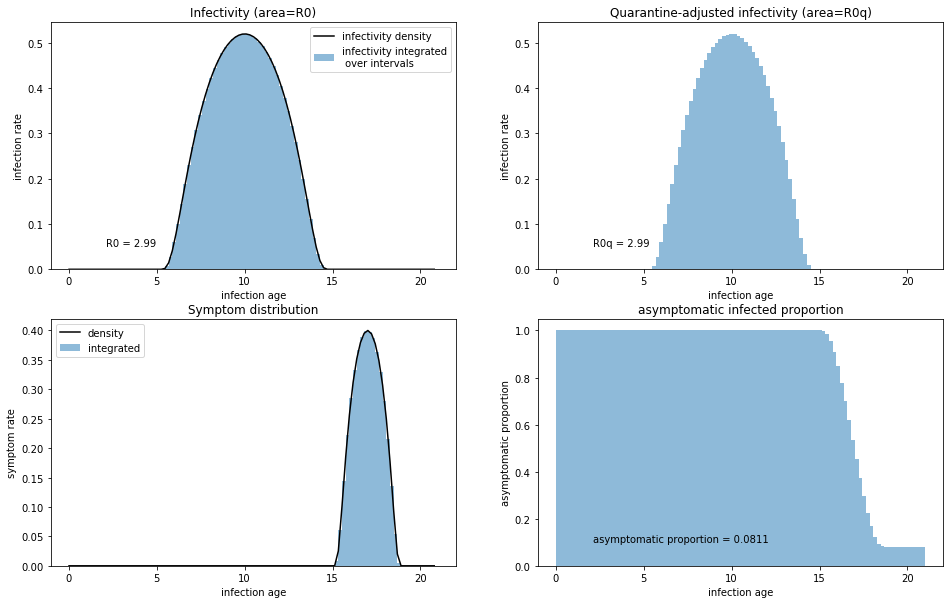

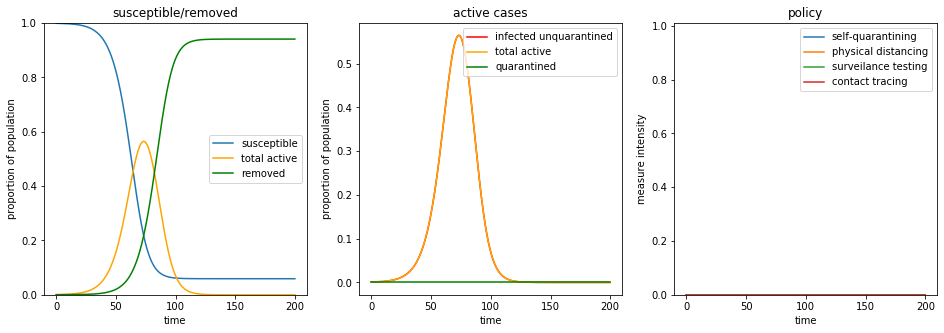

In [2]:
beta_dist=compact_support_function(5,15,scale=0.52,shape=0.3,skew=1)
q_dist=compact_support_function(15,19,scale=0.4,skew=1,shape=0.3)
        
S=simulation(100,beta_dist,q_dist,0.001,policy=lambda S,t:(0,1,0,0),time_scale=21)
_=S.disease_plots(include_cond_dist=False)
_=S.time_plots(200)

## Visualization of the driving dynamics
We make an animation of the "age" make-up of our active cases: at any point in time, we can draw a graph representing the disease age distribution in our active cases. In particular, the red area below represents the unquarantined cases with disease age between 5 and 15: a large red area means more infections: the orange curve on the left will be higher.

The green area below represents unquarantined cases with diease age between 15 and 19: these are the cases that start developing symptoms, and therefore are placed in quarantine. In addition, a large green area means a lot of backtrace activity, which means transfer from unquarantined to quarantined across the age spectrum. In particular, it suppresses the red area and therefore, indirectly, pushes down the orange curve on the left.

The increase of the green quarantined population curve before age 15 is entirely due to contact tracing. We can indeed see it stabilizes at about 75%, which is the efficiency level of the contact tracing we have set. The green quarantined population curve then further increases between ages 15 and 19, because most individuals develop symptoms then (and this increase drives the contact tracing)

## Scenario 1
We run a simulation under the following parameters:
 * individuals are fully and perfectly quarantined upon symptom onset
 * we don't do surveillance testing
 * we don't do contact tracing.
Since the disease in only infective prior to symptom onset, the quarantining has no epidynamic effect. You can that the waxing and waning of the epidemic is reflected in the demographics of the diseased population, though.


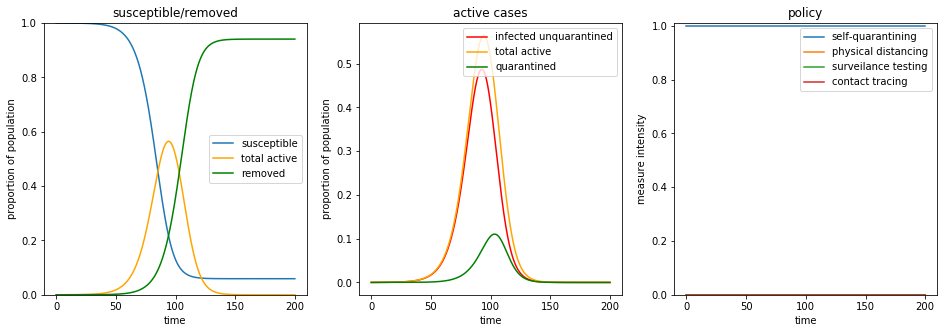

In [5]:
def policy1(sim,t):
    global onoff
    C_quar=1 #let's assume self-quaranting measures in place
    C_contact=1.0
    C_test=0.0
    if t>40:
        C_trace=0
    else:
        C_trace=0*(t/40)
    return (C_quar,C_contact,C_test,C_trace)    
        
S1=simulation(5*21,beta_dist,q_dist,0.0001,policy=policy1,time_scale=21)

_=S1.time_plots(200)
A=anim(S1,0.01)
plt.close(A._fig)
HTML(A.to_html5_video())

## Scenario 2

We run a simulation under the following parameters:
 * individuals are fully and perfectly quarantined upon symptom onset
 * we don't do surveillance testing
 * individuals who are symptomatic are contact traced with 75% efficiency (this 75% efficiency applies at each level of contact tracing)
 * in order to make sure the dynamics relax appropriately, we phase in the contact tracing. This doesn't seem to have much effect, but it's good practice.

We see a noticeable reduction in epidemic intensity, and a much lower stabilization level.


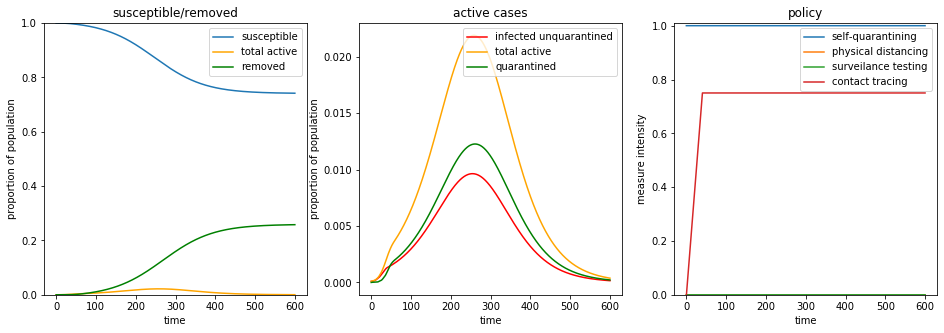

In [6]:
def policy2(sim,t):
    global onoff
    C_quar=1 #let's assume self-quaranting measures in place
    C_contact=1.0
    C_test=0.0
    if t>40:
        C_trace=0.75
    else:
        C_trace=0.75*(t/40)
    return (C_quar,C_contact,C_test,C_trace)    

S2=simulation(5*21,beta_dist,q_dist,0.0001,policy=policy2,time_scale=21)_=S2.time_plots(600)
A=anim(S2,0.0003)
plt.close(A._fig)
HTML(A.to_html5_video())